# Assessment of Renewable Energy Potentials based on Land Availability

The analysis of land availability for renewable energy potentials is divided into three stages. In this script, we will focus on the first stage: **Land Use**.

-Goal: find out available lands that can be used for renewable energy development.

-Steps:

1. Import data
2. Data unification
3. Calculate the total area and plot the map
4. Merge the layers



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # graph plotting package
from matplotlib.patches import Patch # for legend editing
import os # operating system interfaces 
import numpy as np # array and data sorting package
import pandas as pd # dataframe sorting package
import geopandas as gpd # geospatial data processing package
from geopandas import datasets, GeoDataFrame, read_file # geospatial data processing package
from geopandas.tools import overlay # for overlay function
import shapely.speedups # geospatial data speedup package
import rasterio # geospatial data (raster file) processing package
from rasterio.plot import show # plot the raster data
from shapely import wkt # provide dumpers and loaders inspired by Python’s pickle module
from shapely.geometry import Point # processing for data in point form
import pyproj # self-defined coordination reference system
from pyproj import CRS # self-defined coordination reference system
from pyproj import Geod # performs forward and inverse geodetic, or Great Circle, computations

shapely.speedups.enable() # spped up the calculation of mapping in shapely library
name = 'Vietnam'

## 1. Import data

a. Import the **basemap** which is the **administrative level**. Here we use **level 2** to proceed.

b. Import the **map layers** that are occupied and not suitable for renewable energy development. Here the layers include: 

(a) Landuse Map (residential areas, industrial areas, military areas, etc.) <br>
(b) Building Map (building outline from a bird's eye view)<br>
(c) Water Areas Map (Rivers, Lakes, Reservoirs, Docks, Glaciers, etc.) <br>
(d) Roads Map (road networks, highways, etc)<br>
(e) Railways Map (Railways, Subways, Trams, Lifts, and Cable Cars) <br>
(f) Transport Stations Map (railway stations, subway stations, airports, aprons)<br>
(g) Natural Features Map (mountains, cliffs, volcanos, trees, etc.)
<br>
*The descriptions of the categories can be found in [OpenStreetMap](http://download.geofabrik.de/osm-data-in-gis-formats-free.pdf)


In [2]:
%%time
# gdf: geodataframe
admin = 'Vietnam/00_data_vector/01_admin_level2/vnm_admbnda_adm2_gov_20201027.shp' # admin level 2
land = 'Vietnam/00_data_vector/02_occupied_land/gis_osm_landuse_a_free_1.shp' # (a) Landuse (forests, parks, residential, industrial, military, etc.) (polygon)
build = 'Vietnam/00_data_vector/03_buildings/gis_osm_buildings_a_free_1.shp' # (b) Building (polygon)
water = 'Vietnam/00_data_vector/04_water_area/gis_osm_water_a_free_1.shp' # (c) Water Areas Map (Rivers, Lakes, Reservoirs, Docks, Glaciers, etc.)
roads = 'Vietnam/00_data_vector/05_roads/gis_osm_roads_free_1.shp' # (d) Roads Map (road networks, highways, etc) (line)
rails = 'Vietnam/00_data_vector/06_railways/gis_osm_railways_free_1.shp' # (e) Railways Map (Line) (Railways, Subways, Trams, Lifts, and Cable Cars)
trans = 'Vietnam/00_data_vector/07_transport_stations/gis_osm_transport_free_1.shp' # (f) Transport Stations Map (railway stations, subway stations, airports, aprons)
natur = 'Vietnam/00_data_vector/08_natural_features/natural.shp' # (f) Transport Stations Map (railway stations, subway stations, airports, aprons)

admin_gdf = gpd.read_file(admin)
land_gdf = gpd.read_file(land)
build_gdf = gpd.read_file(build)
water_gdf = gpd.read_file(water)
roads_gdf = gpd.read_file(roads)
rails_gdf = gpd.read_file(rails)
trans_gdf = gpd.read_file(trans)
natur_gdf = gpd.read_file(natur)

Wall time: 2min 33s


## 2. Data Unification

### a. Sort and re-index the **administrative level** map

In [3]:
new_admin_gdf = admin_gdf.copy()
new_admin_gdf = new_admin_gdf[['ADM0_EN', 'ADM1_EN','ADM2_EN', 'geometry']] # only select necessary columns
new_admin_gdf.rename(columns={'ADM0_EN': 'country_name','ADM1_EN': 'ad_lv_1','ADM2_EN': 'ad_lv_2','geometry': 'geometry'}, inplace = True)
print(new_admin_gdf.columns)

Index(['country_name', 'ad_lv_1', 'ad_lv_2', 'geometry'], dtype='object')


### b. Sort and re-index the other map layers.
Only three columns shall be kept: **type/fclass, name, geometry**

In [4]:
new_dict={} #empty dictionary
natur_gdf = natur_gdf.rename(columns={'type': 'fclass'})
titles_array = [land_gdf,build_gdf,water_gdf,roads_gdf,rails_gdf,trans_gdf,natur_gdf] # list the titles of each column for selection
new_name = ['new_land_gdf','new_build_gdf', 'new_water_gdf', 'new_roads_gdf', 'new_rails_gdf', 'new_trans_gdf', 'new_natur_gdf']
for i in range(len(titles_array)): #for looping 
    new_dict[new_name[i]] = titles_array[i].copy() # new gdf name according to new_name
    new_dict[new_name[i]] = new_dict[new_name[i]][['fclass', 'name', 'geometry']] # only select necessary columns

# some data need to be reduced since not all are relevant to the evaluation of available land.
# set up a list that need to remove. And remove the names in column 'fclass' that are included in the list.
# drop columns that are not needed for calculations
drop_roads = ['footway','residential','unclassified','living_street','pedestrian','track_grade1','bridleway','path','steps','unknown']
new_dict['new_roads_gdf'] = new_dict['new_roads_gdf'][~new_dict['new_roads_gdf']['fclass'].isin(drop_roads)]

drop_rails = ['subway','drag_lift','chair_lift','cable_car','gondola','goods','other_lift']
new_dict['new_rails_gdf'] = new_dict['new_rails_gdf'][~new_dict['new_rails_gdf']['fclass'].isin(drop_rails)]

drop_trans = ['tram_stop','bus_stop','bus_station','taxi_rank','helipad','ferry_terminal','aerialway_station']
new_dict['new_trans_gdf'] = new_dict['new_trans_gdf'][~new_dict['new_trans_gdf']['fclass'].isin(drop_trans)]

for i in range(len(new_dict)): print(new_dict[new_name[i]].columns)

Index(['fclass', 'name', 'geometry'], dtype='object')
Index(['fclass', 'name', 'geometry'], dtype='object')
Index(['fclass', 'name', 'geometry'], dtype='object')
Index(['fclass', 'name', 'geometry'], dtype='object')
Index(['fclass', 'name', 'geometry'], dtype='object')
Index(['fclass', 'name', 'geometry'], dtype='object')
Index(['fclass', 'name', 'geometry'], dtype='object')


### c. Scale up the **buffer** of each vector (might take some time to scale: approx. 5-6mins)

In [7]:
%%time
# functions of geopandas package
# increase the buffer to make every layer become polygons (longitude crs. unit in 0.01 degree of longitude (1.11 km))
for i in range(len(new_dict)): 
    new_dict[new_name[i]]['geometry'] = new_dict[new_name[i]].geometry.buffer(0.01, cap_style = 3, join_style = 1)

<timed exec>:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Wall time: 4min 58s


## 3. Calculate the total area and plot the map

[EPSG:4326/WGS 84](https://epsg.io/4326) - World Geodetic System 1984, used in GPS (common longtitude/latitude system) <br>
[EPSG:3405/VN-2000 / UTM zone 48N](https://epsg.io/3405) - Accurate projection and caluclation of areas (units in meters) <br>
*UTM: Universal Transverse Mercator coordinate system

### a. Calculate the total area of Vietnam via **basemap** (**administrative level in Vietnam (VN)**)

In [8]:
# crs for system unit in meter, from https://epsg.io/
crs_m = CRS.from_proj4("+proj=utm +zone=48 +ellps=WGS84 +towgs84=-192.873,-39.382,-111.202,-0.00205,-0.0005,0.00335,0.0188 +units=m +no_defs ")

# Original CRS: EPSG:4326 (Unit: longtitude, latitiude)
admin_m_gdf = new_admin_gdf.to_crs(crs_m) # Reprojection to crs
admin_km_df = admin_m_gdf.area/ 10**6 # Areas in square kilometers

save_admin_gdf = new_admin_gdf.drop(columns=['geometry']) # remove column 'geometry' and add column 'area'
save_admin_gdf['area_km2'] = admin_km_df
#save_admin_gdf.to_csv(r'Vietnam/01_output_stage1/01_vn_admin_level2.csv', index = True) # Save csv file

print('Total area of', name, ':', admin_km_df.sum(axis = 0, skipna = True),'km^2')

Total area of Vietnam : 334820.73259775393 km^2


Compared to the [official value of total area (310,070 km^2 in 2018)](https://data.worldbank.org/indicator/AG.LND.TOTL.K2?locations=VN), there are deviations because the data is calculated based on different CRSs, the projections of the map will cause the differences.

### b. Plot the maps and save the graphs
*The graphs below are just for visualization and they won't related to the further programming process. Hence the lines for store the graphs are kep in notes. You can also re-validate them if you want to see the output graph files.

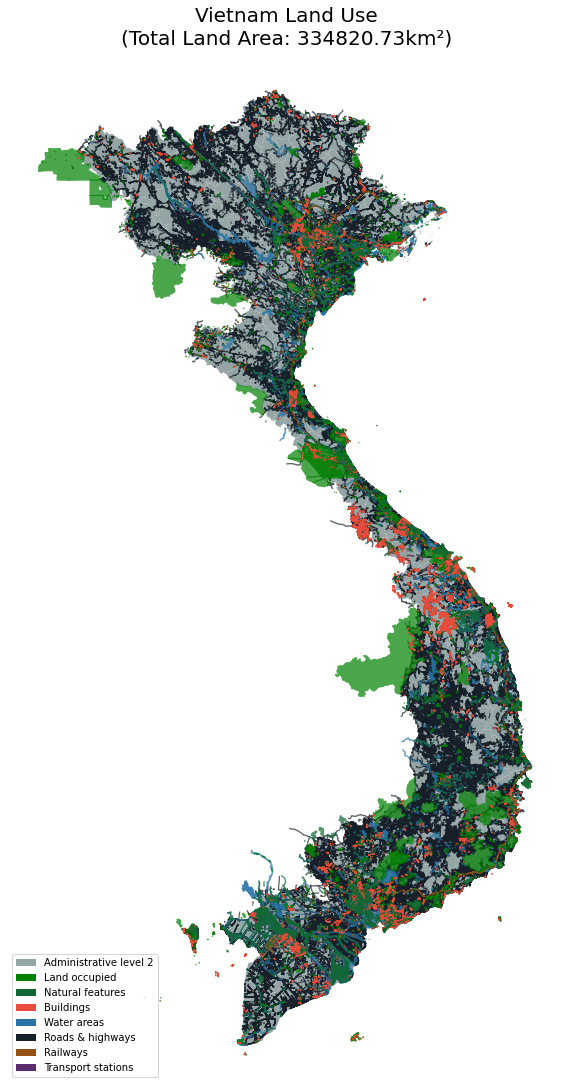

In [19]:
# Land Use Map Analysis Picture
fig, ax = plt.subplots(figsize=(10, 20)) # Plot the data with a modified spatial extent

# Use VN_landuse boundary to define all sizes of the maps
ax.set_xlim(101, 110)
ax.set_ylim(8, 24)

plot_arr = ['new_roads_gdf', 'new_rails_gdf', 'new_water_gdf', 'new_trans_gdf', 'new_land_gdf','new_build_gdf', 'new_natur_gdf']
color_arr = ['#17202A', '#935116', '#2874A6', '#5B2C6F', 'g','#E74C3C', '#126635']
legend_arr = ['Land occupied', 'Buildings', 'Water areas', 'Roads & highways', 'Railway', 'Transport stations', 'Natural features']

new_admin_gdf.plot(ax=ax, categorical=True, legend=True, color='#95A5A6') # add basemap to the plot (grey)
legend_elements = np.array(['Administrative level 2']) # Define Legend
for i in range(len(new_dict)):
    new_dict[plot_arr[i]].plot(ax=ax, markersize=10, alpha=0.7, categorical=True, legend=True, color=color_arr[i]) # add the roads layer to the plott

# Define Legend
legend_elements = [Patch(facecolor='#95A5A6', label='Administrative level 2'),
                   Patch(facecolor='g', label='Land occupied'),
                   Patch(facecolor='#126635', label='Natural features'),
                   Patch(facecolor='#E74C3C', label='Buildings'),
                   Patch(facecolor='#2874A6', label='Water areas'),
                   Patch(facecolor='#17202A', label='Roads & highways'),
                   Patch(facecolor='#935116', label='Railways'),
                   Patch(facecolor='#5B2C6F', label='Transport stations')]


ax.legend(handles=legend_elements, loc='lower left')

# Set title
ax.set_title("Vietnam Land Use\n(Total Land Area: {0:.{1}f}km\u00b2)".format(admin_km_df.sum(axis = 0, skipna = True), 2), fontsize=20)
ax.set_axis_off()

plt.savefig(r'Vietnam/01_output_stage1/01_vn_land_use_analysis.tiff', dpi=500) # Save the graph into tiff file
plt.show()

## 4. Merge the layers

### a. Calculate the total area

Merging may take some time: approx. 20-25min

In [12]:
%%time 
# Overlay: basemap minus all occupied land layers  
overlay = [new_admin_gdf, new_dict['new_land_gdf'], new_dict['new_build_gdf'], new_dict['new_water_gdf'], new_dict['new_roads_gdf'], new_dict['new_rails_gdf'], new_dict['new_trans_gdf'], new_dict['new_natur_gdf']]
merge_dict = {} # empty dictionary
merge_dict['merge1_gdf'] = gpd.overlay(overlay[0], overlay[1], how = 'difference') # execute the first overlay gdfs
for i in range(2, len(overlay)): 
    merge_dict['merge{0}_gdf'.format(i)] = gpd.overlay(merge_dict['merge{0}_gdf'.format(i-1)], overlay[i], how = 'difference') # execute the rest of teh overlay gdfs

merge_dict['merge7_gdf'].to_file(r'Vietnam/01_output_stage1/01_vn_available_land.shp') # Save the shapefile

<timed exec>:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


Wall time: 14min 18s


In [15]:
# Original CRS: EPSG:4326 (Unit: longtitude, latitiude)
merge_m_gdf = merge_dict['merge7_gdf'].to_crs(crs_m) # Reprojection to crs
merge_km_df = merge_m_gdf.area/ 10**6 # Areas in square kilometers

merge_save_gdf = merge_dict['merge7_gdf'].drop(columns=['geometry']) # remove column 'geometry' and add column 'area'
merge_save_gdf['area_km2'] = merge_km_df
merge_save_gdf.to_csv(r'Vietnam/01_output_stage1/01_vn_avail_land.csv', index = True) # Save csv file

print('Total area of available land in', name, ':', merge_km_df.sum(axis = 0, skipna = True),'km^2') # Total areas in square kilometers

Total area of available land in Vietnam : 97818.83178687205 km^2


### b. Plot the maps and save the graphs

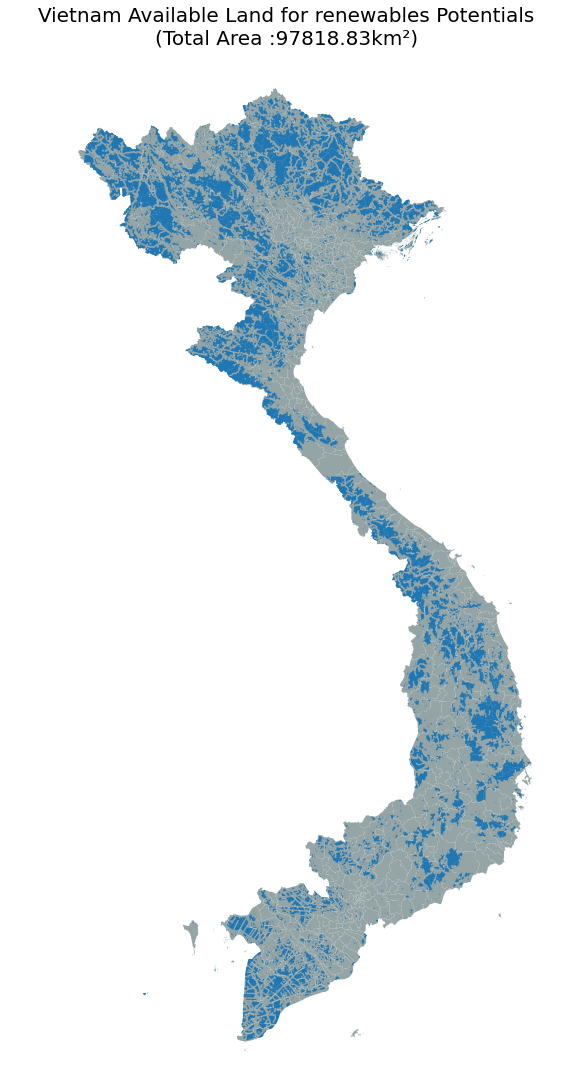

In [16]:
# Plot the data with a modified spatial extent
fig, ax = plt.subplots(figsize=(10, 20))

# Use VN_landuse boundary to define all sizes of the maps
ax.set_xlim(101, 110)
ax.set_ylim(8, 24)

new_admin_gdf.plot(ax=ax, categorical=True, legend=True, color='#95A5A6') # add basemap to the plot (grey)
merge_dict['merge7_gdf'].plot(ax=ax, categorical=True, legend=True) # add basemap to the plot (default color)

# Set titles
ax.set_title('Vietnam Available Land for renewables Potentials\n(Total Area :{0:.{1}f}km\u00b2)'.format(merge_km_df.sum(axis = 0, skipna = True), 2), fontsize=20)
ax.set_axis_off()

plt.savefig(r'Vietnam/01_output_stage1/01_vn_available_land.tif', dpi=400) # Save the graph into tiff file
plt.show()